In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
data_dir = '../data/Animals-10/raw-img'
transform = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.RandomHorizontalFlip(),  # 随机水平翻转
     transforms.ColorJitter(brightness=0.15, contrast=0.15, hue=0.1),  # 随机改变颜色属性
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Dataset = datasets.ImageFolder(root=data_dir, transform=transform)

num_classes = len(Dataset.classes)
print(f"Number of classes: {num_classes}")
num_samples = len(Dataset)
print(f"Number of samples: {num_samples}")

Number of classes: 10
Number of samples: 26179


In [3]:
train_indices = []
test_indices = []

# 按类别划分
for label in range(len(Dataset.classes)):
    # 找到该类别所有样本的索引
    class_indices = [i for i, (_, class_label) in enumerate(Dataset.imgs) if class_label == label]
    random.shuffle(class_indices)  # 打乱顺序

    # 划分
    split_index = int(0.85 * len(class_indices))  # 80% 训练集，20% 测试集
    train_indices.extend(class_indices[:split_index])
    test_indices.extend(class_indices[split_index:])

In [4]:
# 创建训练集和测试集子集
train_subset = Subset(Dataset, train_indices)
test_subset = Subset(Dataset, test_indices)

# 创建数据加载器
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# 打印训练集和测试集的大小
print(f"Training samples: {len(train_subset)}")
print(f"Test samples: {len(test_subset)}")

Training samples: 22248
Test samples: 3931


In [5]:
# Resnet 18/34
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# Resnet 50/101/152
class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckResidualBlock, self).__init__()
        # 1x1 卷积，用于降维
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        # 3x3 卷积，用于提取特征
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        # 1x1 卷积，用于升维
        self.conv3 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * 4)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        
        # 通过三个卷积层
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        
        # 如果有 downsample，调整输入的维度匹配输出
        if self.downsample:
            residual = self.downsample(x)
        
        # 加上残差并通过 ReLU
        out += residual
        out = self.relu(out)
        
        return out


In [6]:
# Resnet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [7]:
# 交叉验证参数
k_folds = 3
fold_size = len(train_subset) // k_folds

# 创建 k 折交叉验证的索引
indices = list(range(len(train_subset)))
random.shuffle(indices)

# 划分 k 折
folds = [indices[i:i + fold_size] for i in range(0, len(indices), fold_size)]

In [9]:
# 超参数
num_epochs = 20
batch_size = 64
learning_rate = 0.001

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)

total_step = len(train_loader)
total_step

696

In [10]:
# 初始化存储loss和准确率的列表
train_losses = []
val_accuracies = []
best_val_accuracy = 0

In [11]:
# 进行 k 折交叉验证
for fold in range(k_folds):
    print(f"\nFold {fold + 1}/{k_folds}")

    # 划分训练集和验证集
    val_indices = folds[fold]  # 当前折的验证集索引
    train_indices = [idx for i in range(k_folds) if i != fold for idx in folds[i]]  # 其他折的训练集索引

    # 创建子集
    train_k_subset = Subset(train_subset, train_indices)
    val_subset = Subset(train_subset, val_indices)

    # 创建数据加载器
    train_k_loader = DataLoader(train_k_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # 打印训练和验证集的大小
    print(f"Training samples for fold {fold + 1}: {len(train_k_subset)}, Validation samples: {len(val_subset)}")
    
    # 训练及验证
    for epoch in range(num_epochs):
        # 训练
        model.train()
        running_loss = 0.0

        # 训练进度条
        train_loader_tqdm = tqdm(train_k_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]', leave=True)
        
        for images, labels in train_loader_tqdm:
            # 将数据移动到 GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # 前向传播
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 累计损失
            running_loss += loss.item()
            
        # 计算并保存当前epoch的平均loss
        epoch_loss = running_loss / len(train_k_loader)
        train_losses.append(epoch_loss)
                
        # 验证
        model.eval()
        correct = 0
        total = 0
        
        val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]', leave=True)
        
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images = images.to(device)
                labels = labels.to(device)
                
                # 前向传播
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                # 统计准确率
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        # 打印每个 epoch 的损失和验证集准确率
        print(f'Fold [{fold+1}/{k_folds}], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # 动态绘图
        # plot_metrics(epoch)

        # 如果验证集准确率提升，保存模型
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model_cpu.pth')
            print(f"Validation accuracy improved to {best_val_accuracy:.2f}%, model saved.")


Fold 1/3
Training samples for fold 1: 14832, Validation samples: 7416


Epoch 1/20 [Training]:   3%|█▋                                                        | 13/464 [00:44<25:36,  3.41s/it]


KeyboardInterrupt: 

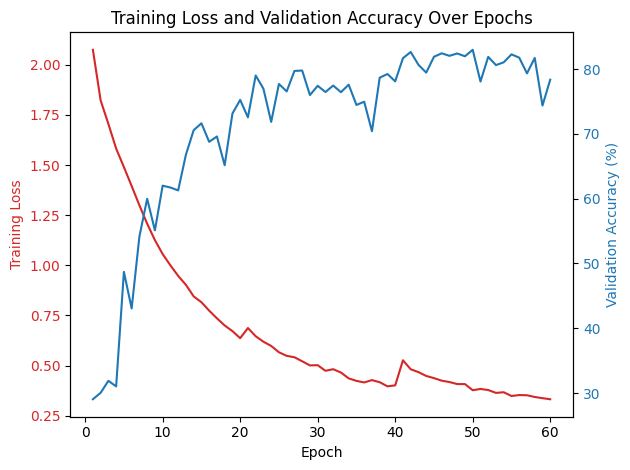

In [16]:
def plot_final_metrics(train_losses, val_accuracies):
    fig, ax1 = plt.subplots()

    # 绘制训练损失
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, color='tab:red', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 绘制验证准确率
    ax2 = ax1.twinx()  # 创建共享 x 轴的第二个 y 轴
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, color='tab:blue', label='Val Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 设置图像标题
    plt.title('Training Loss and Validation Accuracy Over Epochs')
    fig.tight_layout()  # 调整布局避免重叠
    plt.show()

# 调用函数绘制图像
plot_final_metrics(train_losses, val_accuracies)

In [20]:
# 加载训练过程中保存的最佳模型
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()  # 切换到评估模式

# 在测试集上进行测试
correct = 0
total = 0

# 使用 tqdm 显示测试进度
test_loader_tqdm = tqdm(test_loader, desc='Testing', leave=True)

# 不需要计算梯度，因此用 torch.no_grad() 包裹测试过程
with torch.no_grad():
    for images, labels in test_loader_tqdm:
        # 将数据移动到 GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # 计算准确率
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算测试集准确率
test_accuracy = 100 * correct / total
print(f'Test Accuracy of the model on the {total} test images: {test_accuracy:.2f}%')


Testing: 100%|███████████████████████████████████████████████████████████████████████| 123/123 [00:43<00:00,  2.80it/s]

Test Accuracy of the model on the 3931 test images: 79.57%
